# Import Data Set

In [1]:
import boto3
import pandas as pd
import os
from configparser import ConfigParser
from smart_open import smart_open

config = ConfigParser()

config_file = ('config.ini')
config.read(config_file)
default = config['aws.data']


aws_key = default['accessKey']
aws_secret = default['secretAccessKey']

bucket_name = 'texttoxicity-train-test'
object_key = 'train.csv'

object_key_train = 'train.csv'
object_key_test ='test.csv'

path_train = 's3://{}:{}@{}/{}'.format(aws_key, aws_secret, bucket_name, object_key_train)
path_test = 's3://{}:{}@{}/{}'.format(aws_key, aws_secret, bucket_name, object_key_test)

train = pd.read_csv(smart_open(path_train))
test =pd.read_csv(smart_open(path_test))

In [2]:
train.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.0,4,47


# Feature Extraction

In [3]:
train['total_length'] = train['comment_text'].apply(len)
train['capitals'] = train['comment_text'].apply(lambda comment: sum(1 for c in comment if c.isupper()))
train['caps_vs_length'] = train.apply(lambda row: float(row['capitals'])/float(row['total_length']),axis=1)
train['num_exclamation_marks'] = train['comment_text'].apply(lambda comment: comment.count('!'))
train['num_question_marks'] = train['comment_text'].apply(lambda comment: comment.count('?'))
train['num_punctuation'] = train['comment_text'].apply(lambda comment: sum(comment.count(w) for w in '.,;:'))
train['num_symbols'] = train['comment_text'].apply(lambda comment: sum(comment.count(w) for w in '*&$%'))
train['num_words'] = train['comment_text'].apply(lambda comment: len(comment.split()))
train['num_unique_words'] = train['comment_text'].apply(lambda comment: len(set(w for w in comment.split())))
train['words_vs_unique'] = train['num_unique_words'] / train['num_words']
train['num_smilies'] = train['comment_text'].apply(lambda comment: sum(comment.count(w) for w in (':-)', ':)', ';-)', ';)')))

In [4]:
features = ('total_length', 'capitals', 'caps_vs_length', 'num_exclamation_marks','num_question_marks', 'num_punctuation', 'num_words', 'num_unique_words','words_vs_unique', 'num_smilies', 'num_symbols')
columns = ('target', 'severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat', 'funny', 'wow', 'sad', 'likes', 'disagree', 'sexual_explicit','identity_annotator_count', 'toxicity_annotator_count')
rows = [{c:train[f].corr(train[c]) for c in columns} for f in features]
train_correlations = pd.DataFrame(rows, index=features)
train_correlations

,disagree,funny,identity_annotator_count,identity_attack,insult,likes,obscene,sad,severe_toxicity,sexual_explicit,target,threat,toxicity_annotator_count,wow
total_length,0.017617,-0.084710,0.020840,0.053430,0.009085,0.060639,0.009823,-0.019940,0.007962,0.019882,0.006444,-0.013198,-0.030894,0.002572
capitals,0.003928,-0.039221,0.012405,0.050489,0.026358,0.018707,0.027995,-0.005448,0.025127,0.014144,0.026120,0.000721,-0.009082,0.009687
caps_vs_length,-0.021716,0.021263,-0.005510,-0.008477,-0.006029,-0.038470,0.017088,0.002848,0.010594,-0.003575,-0.005344,0.000822,0.015381,-0.000603
num_exclamation_marks,-0.009384,0.007073,0.000869,0.017085,0.052533,-0.007866,0.056108,0.005158,0.035388,0.019437,0.055152,0.021267,0.024115,0.002225
num_question_marks,-0.002180,-0.009290,0.006305,0.028554,0.014366,-0.002731,0.019233,0.002023,0.011662,0.015987,0.019308,-0.000430,-0.003307,0.001263
num_punctuation,0.001415,-0.057187,0.018050,0.042990,0.018911,0.029581,0.017701,-0.016511,0.013266,0.018985,0.016974,-0.006479,-0.021231,0.001959
num_words,0.016121,-0.084398,0.020595,0.050527,0.011975,0.059481,0.014536,-0.019412,0.009696,0.021525,0.009579,-0.009893,-0.029856,0.002714
num_unique_words,0.019634,-0.085764,0.020787,0.053659,0.019494,0.063874,0.017918,-0.018110,0.011900,0.022816,0.016702,-0.008946,-0.029814,0.003490
words_vs_unique,-0.020712,0.079045,-0.019749,-0.048941,0.001135,-0.060162,-0.003007,0.016223,-0.005329,-0.015748,0.001172,0.009367,0.027853,-0.004150
num_smilies,-0.010936,0.010109,-0.000576,-0.008337,-0.009401,-0.016607,-0.001024,-0.002133,-0.003877,-0.000414,-0.010040,-0.003190,-0.003030,-0.002777


In [5]:
train.fillna(0,inplace=True)
train.target = train.target.apply(lambda x: 1 if x>0.45 else 0)

In [6]:
from string import punctuation
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords

In [7]:
stop_words = set(stopwords.words('english')) 

train['comment_text'] = train.comment_text.apply(lambda x: x.lower())

train['cleaned_comment'] = train.comment_text.apply(lambda x: word_tokenize(x))

train['cleaned_comment'] = train.cleaned_comment.apply(lambda x: [w for w in x if w not in stop_words])

train['cleaned_comment'] = train.cleaned_comment.apply(lambda x: ' '.join(x))

train.drop('comment_text',axis=1,inplace=True)

# Modelling

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [9]:
import numpy as np
#traget variable
y = train.target

#test-triain split
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.33,random_state=53)

# Initialize a CountVectorizer object: count_vectorizer
count_vectorizer = CountVectorizer(stop_words="english")
count_train = count_vectorizer.fit_transform(X_train["cleaned_comment"])

y_train = np.asarray(y_train.values)

# Pick up the most effective words
ch2 = SelectKBest(chi2, k = 300)

In [10]:
X_new = ch2.fit_transform(count_train, y_train)

# Transform the test data using only the 'text' column values: count_test 
count_test = count_vectorizer.transform(X_test["cleaned_comment"])
X_test_new = ch2.transform(X=count_test)

## 1. Naive Bayes

Multinomial Naive Bayes is a specialized version of Naive Bayes that is designed more for text documents. Whereas simple naive Bayes would model a document as the presence and absence of particular words, multinomial naive bayes explicitly models the word counts and adjusts the underlying calculations to deal with in.
It estimates the conditional probability of a particular word given a class as the relative frequency of term t in documents belonging to class(c). The variation takes into account the number of occurrences of term t in training documents from class (c),including multiple occurrences.

In [11]:
from sklearn.naive_bayes import MultinomialNB

In [12]:
clf = MultinomialNB()

# Fit the classifier to the training data
clf.fit(X_new, y_train)

# Create the predicted tags: pred
pred_nb = clf.predict(X_test_new)

## 2. Decision Tree Classifier

The general motive of using Decision Tree is to create a training model which can use to predict class or value of target variables by learning decision rules inferred from prior data(training data).
A decision tree is a flowchart-like tree structure where an internal node represents feature(or attribute), the branch represents a decision rule, and each leaf node represents the outcome. The topmost node in a decision tree is known as the root node. It learns to partition on the basis of the attribute value. It partitions the tree in recursively manner call recursive partitioning. This flowchart-like structure helps you in decision making. It's visualization like a flowchart diagram which easily mimics the human level thinking. That is why decision trees are easy to understand and interpret.

In [13]:
from sklearn.tree import DecisionTreeClassifier

In [14]:
clf = DecisionTreeClassifier()

# Fit the classifier to the training data
clf.fit(X_new, y_train)

# Create the predicted tags: pred
pred_dt = clf.predict(X_test_new)

## 3. Random Forest

The random forest is a model made up of many decision trees. Rather than just simply averaging the prediction of trees (which we could call a “forest”), this model uses two key concepts that gives it the name random:

1.Random sampling of training data points when building trees.

2.Random subsets of features considered when splitting node.

In [15]:
from sklearn.ensemble import RandomForestClassifier

In [16]:
clf = RandomForestClassifier()

# Fit the classifier to the training data
clf.fit(X_new, y_train)

# Create the predicted tags: pred
pred_rf = clf.predict(X_test_new)

C:\Users\HarshithaGS\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


## 4.Logistic Regression

 The logistic regression model computes a weighted sum of the input variables similar to the linear regression, but it runs the result through a special non-linear function, the logistic function or sigmoid function to produce the output y. 

In [17]:
from sklearn.linear_model import LogisticRegression

In [18]:
clf = LogisticRegression()

# Fit the classifier to the training data
clf.fit(X_new, y_train)

# Create the predicted tags: pred
pred_lr = clf.predict(X_test_new)

C:\Users\HarshithaGS\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


# Model Comparison

In [27]:
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import log_loss
from sklearn.pipeline import Pipeline

from sklearn.metrics import roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import StratifiedKFold
from scipy import interp

1.Comparing confusion matrices of all models

Confusion Matrix of Naive Bayes


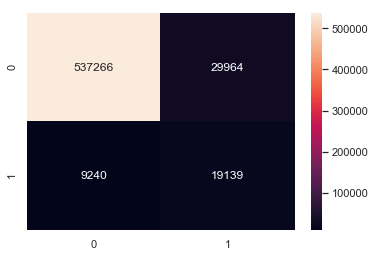

In [39]:
# We use ax parameter to tell seaborn which subplot to use for this plot
print('Confusion Matrix of Naive Bayes')
sns.heatmap(metrics.confusion_matrix(pred_nb,y_test),annot=True,fmt='2.0f')

Confusion Matrix of Decision Tree


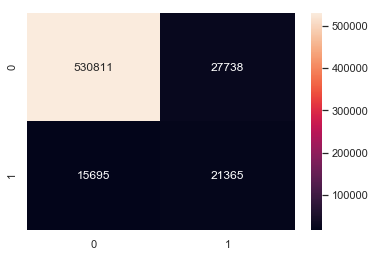

In [40]:
print('Confusion Matrix of Decision Tree')
sns.heatmap(metrics.confusion_matrix(pred_dt,y_test),annot=True,fmt='2.0f')

Confusion Matrix of Random Forest


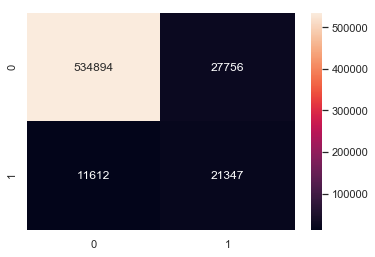

In [41]:
print('Confusion Matrix of Random Forest')
sns.heatmap(metrics.confusion_matrix(pred_rf,y_test),annot=True,fmt='2.0f')

Confusion Matrix of Logistic Regression


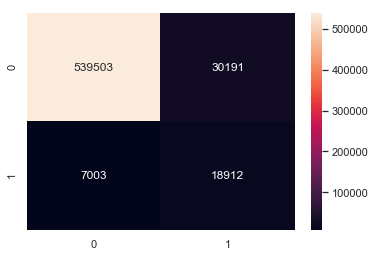

In [42]:
print('Confusion Matrix of Logistic Regression')
sns.heatmap(metrics.confusion_matrix(pred_lr,y_test),annot=True,fmt='2.0f')

2.Comparing Accuracy score of all models

In [23]:
score = metrics.accuracy_score(y_test, pred_nb)
print('Accuracy of Naive Bayes Model is:',score)
score = metrics.accuracy_score(y_test, pred_dt)
print('Accuracy of Decision Tree Model is:',score)
score = metrics.accuracy_score(y_test, pred_rf)
print('Accuracy of Random Forest Model is:',score)
score = metrics.accuracy_score(y_test, pred_lr)
print('Accuracy of Logistic Regression Model is:',score)

Accuracy of Naive Bayes Model is: 0.9341782948209312
Accuracy of Decision Tree Model is: 0.9270779991571652
Accuracy of Random Forest Model is: 0.9339029463960417
Accuracy of Logistic Regression Model is: 0.9375529919796376


3. Comparing F1-score of all models

In [24]:
f1 = metrics.f1_score(y_test, pred_nb)
print('F1 score of Naive Bayes Model is:',score)
f1 = metrics.f1_score(y_test, pred_dt)
print('F1 score of Decision Tree Model is:',score)
f1 = metrics.f1_score(y_test, pred_rf)
print('F1 score of Random Forest Model is:',score)
f1 = metrics.f1_score(y_test, pred_lr)
print('F1 score of Logistic Regression Model is:',score)

F1 score of Naive Bayes Model is: 0.9375529919796376
F1 score of Decision Tree Model is: 0.9375529919796376
F1 score of Random Forest Model is: 0.9375529919796376
F1 score of Logistic Regression Model is: 0.9375529919796376


4. Comparing Log loss of all models

In [25]:
loss = log_loss(y_test,pred_nb)
print('Log loss of Naive Bayes model is :' ,loss)
loss = log_loss(y_test,pred_dt)
print('Log loss of Decision Tree model is :' ,loss)
loss = log_loss(y_test,pred_rf)
print('Log loss of Random Forest model is :' ,loss)
loss = log_loss(y_test,pred_lr)
print('Log loss of Logistic Regression model is :' ,loss)

Log loss of Naive Bayes model is : 2.273413561692878
Log loss of Decision Tree model is : 2.5186577517160136
Log loss of Random Forest model is : 2.2829269437503528
Log loss of Logistic Regression model is : 2.1568526479840164


5. Comparing AUC-ROC of all models

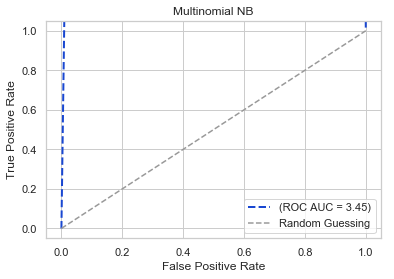

In [51]:
from scipy import interp

fpr, tpr, thresholds = roc_curve(y_test, pred_nb)
mean_tpr += interp(mean_fpr, fpr, tpr)
mean_tpr[0] = 0.0
roc_auc = auc(fpr, tpr)

mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, 
             mean_tpr, 
             color='#1947D1', 
             linestyle='--',
             label='(ROC AUC = %0.2f)' % (mean_auc), 
             lw=2
    )

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random Guessing')    
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multinomial NB')
plt.legend(loc="lower right")
plt.savefig('roc_maxfeatures.eps', dpi=300)
plt.show()

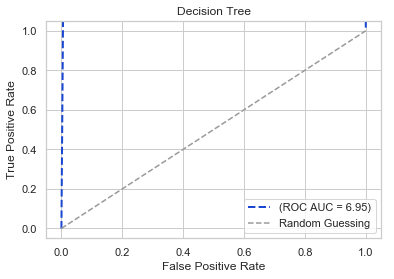

In [56]:
from scipy import interp

fpr, tpr, thresholds = roc_curve(y_test, pred_dt)
mean_tpr += interp(mean_fpr, fpr, tpr)
mean_tpr[0] = 0.0
roc_auc = auc(fpr, tpr)

mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, 
             mean_tpr, 
             color='#1947D1', 
             linestyle='--',
             label='(ROC AUC = %0.2f)' % (mean_auc), 
             lw=2
    )

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random Guessing')    
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree')
plt.legend(loc="lower right")
plt.savefig('roc_maxfeatures.eps', dpi=300)
plt.show()

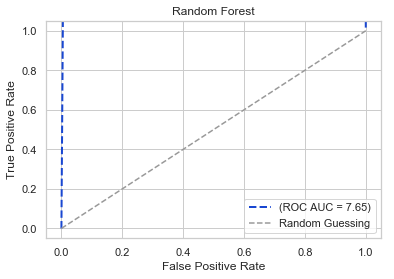

In [57]:
from scipy import interp

fpr, tpr, thresholds = roc_curve(y_test, pred_rf)
mean_tpr += interp(mean_fpr, fpr, tpr)
mean_tpr[0] = 0.0
roc_auc = auc(fpr, tpr)

mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, 
             mean_tpr, 
             color='#1947D1', 
             linestyle='--',
             label='(ROC AUC = %0.2f)' % (mean_auc), 
             lw=2
    )

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random Guessing')    
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest')
plt.legend(loc="lower right")
plt.savefig('roc_maxfeatures.eps', dpi=300)
plt.show()

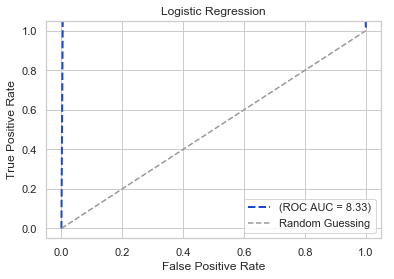

In [58]:
from scipy import interp

fpr, tpr, thresholds = roc_curve(y_test, pred_lr)
mean_tpr += interp(mean_fpr, fpr, tpr)
mean_tpr[0] = 0.0
roc_auc = auc(fpr, tpr)

mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, 
             mean_tpr, 
             color='#1947D1', 
             linestyle='--',
             label='(ROC AUC = %0.2f)' % (mean_auc), 
             lw=2
    )

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random Guessing')    
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression')
plt.legend(loc="lower right")
plt.savefig('roc_maxfeatures.eps', dpi=300)
plt.show()